# Case Base dos Dados
## Análise das Despesas Pagas por município durante o último mandato eleitoral completo de prefeitos e vereadores (2017-2020)

É muito comum ouvirmos que determinada obra só foi retoma ou iniciada por conta da grande coincidência de aquele mesmo ano ser o de eleição municipal, implicando que a obra só é retomada para a reeleição ou a manutenção do partido/coligação na prefeitura de determinada cidade. 

Portanto, para verificarmos se essa percepção possui algum fundo de verdade, esse projeto busca mostrar qual a relação entre o ano eleitoral e o aumento ou não das Despesas Pagas durante o ano eleitoral, utilizando como recorte temporal os anos de 2017 à 2020, que foram último período de mandato municipal completo que tivemos no Brasil.

Para a resolução do case, foi utilizada a tabela *municipio_despesas_orcamentarias* retirada do datalake **siconfi**. O estágio de pagamento do gasto público selecionado foi a conta "Despesas Pagas", pois é, segundo o Portal da Transparência, a conta que mostra o valor efetivo pago após a complitude de uma obra/serviço executado pelo poder público.(fonte: shorturl.at/byI23)

Importando bibliotecas

In [228]:
import basedosdados as bd
import pandas as pd
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid') # ajustando cor do seaborn



#### Fazendo a query da tabela municipio_despesas_orcamentarias do Datalake siconfi

In [215]:
df_g = bd.read_sql(
    '''
    WITH st as (
    select sum(valor) as soma_total, id_municipio
    from
    basedosdados.br_me_siconfi.municipio_despesas_orcamentarias
    WHERE ano > 2016
    AND valor > 0
    AND estagio_bd = 'Despesas Pagas'
    group by id_municipio)
    
    SELECT d.ano, d.sigla_uf, d.id_municipio,  m.nome, d.estagio_bd , sum(d.valor) as gasto, st.soma_total, sum(d.valor)/st.soma_total as media_anual
    FROM basedosdados.br_me_siconfi.municipio_despesas_orcamentarias d
    INNER JOIN basedosdados.br_bd_diretorios_brasil.municipio m on d.id_municipio = m.id_municipio
    inner join st on st.id_municipio = d.id_municipio
    WHERE d.ano > 2016
    AND d.valor > 0
    AND d.estagio_bd = 'Despesas Pagas'
    GROUP BY d.ano, d.id_municipio,d.estagio_bd, d.sigla_uf, m.nome, st.soma_total
    ORDER BY d.ano asc, id_municipio desc
    ''',
    billing_project_id = "basedosdados-1")

Downloading: 100%|███████████████████████████████████████████████████████████| 22024/22024 [00:05<00:00, 3947.23rows/s]


In [216]:
df_g.dtypes

ano               int64
sigla_uf         object
id_municipio     object
nome             object
estagio_bd       object
gasto           float64
soma_total      float64
media_anual     float64
dtype: object

#### Transformando os valores da Despesa Paga em Mio BRL

In [217]:
df_g['gasto'] = df_g['gasto'].div(1000000).round(2)
df_g['soma_total'] = df_g['soma_total'].div(1000000).round(2)
df_g['media_anual'] = df_g['media_anual'].mul(100).round(2)


In [218]:
df_g.head(5)

,ano,sigla_uf,id_municipio,nome,estagio_bd,gasto,soma_total,media_anual
0,2017,GO,5222302,Vila Propício,Despesas Pagas,95.35,442.95,21.53
1,2017,GO,5222203,Vila Boa,Despesas Pagas,95.79,398.32,24.05
2,2017,GO,5222054,Vicentinópolis,Despesas Pagas,141.26,699.26,20.20
3,2017,GO,5222005,Vianópolis,Despesas Pagas,217.56,998.41,21.79
4,2017,GO,5221908,Varjão,Despesas Pagas,65.71,313.82,20.94


Manipulando o dataframe para alinhar ano e id_municipio em ordem decrescente.

In [219]:
df_g['ano_eleitoral'] = df_g['ano'].apply(lambda x: 'Sim' if x in [2020] else 'Não')
df_g = df_g.sort_values(["id_municipio","ano"], ascending = [False,True],ignore_index = True)
df_g.head(5)

,ano,sigla_uf,id_municipio,nome,estagio_bd,gasto,soma_total,media_anual,ano_eleitoral
0,2017,GO,5222302,Vila Propício,Despesas Pagas,95.35,442.95,21.53,Não
1,2018,GO,5222302,Vila Propício,Despesas Pagas,100.20,442.95,22.62,Não
2,2019,GO,5222302,Vila Propício,Despesas Pagas,112.47,442.95,25.39,Não
3,2020,GO,5222302,Vila Propício,Despesas Pagas,134.93,442.95,30.46,Sim
4,2017,GO,5222203,Vila Boa,Despesas Pagas,95.79,398.32,24.05,Não


In [220]:
df_g1 = df_g.copy()

In [221]:
#identificando o ano de maior despesa
df_g1['ano_max_despesa'] = df_g1['ano'].iloc[df_g1.groupby('id_municipio')['gasto'].agg(pd.Series.idxmax)]
df_g1.head()

,ano,sigla_uf,id_municipio,nome,estagio_bd,gasto,soma_total,media_anual,ano_eleitoral,ano_max_despesa
0,2017,GO,5222302,Vila Propício,Despesas Pagas,95.35,442.95,21.53,Não,NaN
1,2018,GO,5222302,Vila Propício,Despesas Pagas,100.20,442.95,22.62,Não,NaN
2,2019,GO,5222302,Vila Propício,Despesas Pagas,112.47,442.95,25.39,Não,NaN
3,2020,GO,5222302,Vila Propício,Despesas Pagas,134.93,442.95,30.46,Sim,2020.0
4,2017,GO,5222203,Vila Boa,Despesas Pagas,95.79,398.32,24.05,Não,NaN


### Criando dataframe com os maiores dispêndios, agrupados por ano e id_municipio. 

Rapidamente, podemos já observar que o ano de 2020 - o ano eleitoral - é o que apresenta maior número de municípios que apresentam esse ano como o de maior dispêndio na conta Despesa Pagas.

In [222]:
df_max = df_g1.iloc[df_g1.groupby('id_municipio')['gasto'].agg(pd.Series.idxmax)] # agregando por id onde max é presente
df_max_ano = pd.DataFrame(df_max['ano'].value_counts().rename('nº_municípios_max_despesa'))


Text(0, 0.5, 'Quantidade de municípios')

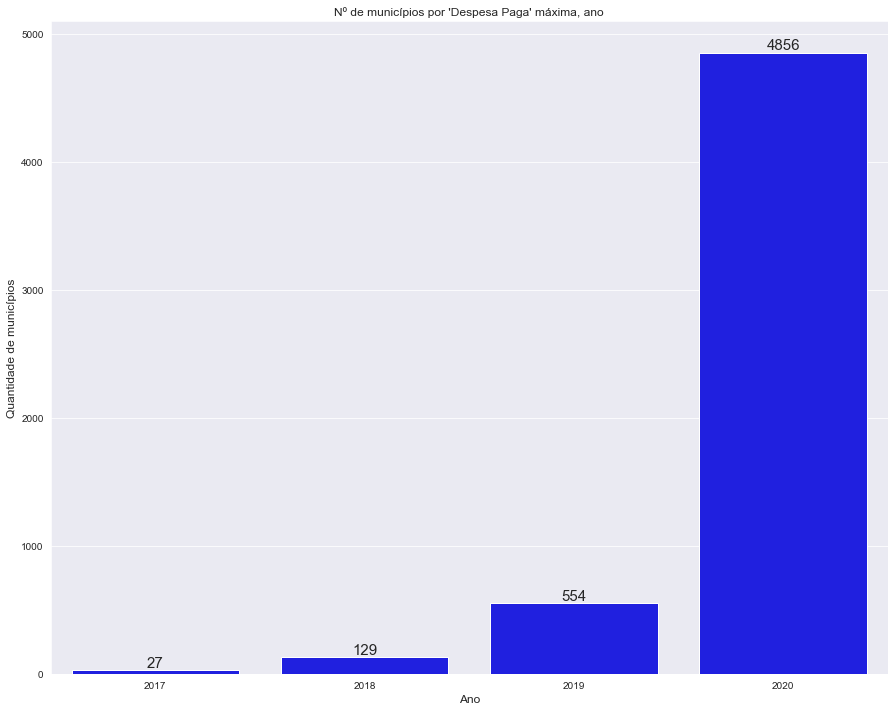

In [223]:
plt.figure(figsize=(15, 12))
plot = sns.barplot(x=df_max_ano.index,y = df_max_ano['nº_municípios_max_despesa'],data=df_max_ano,color = 'blue')
plot.bar_label(plot.containers[0], size= 15)
plt.title("Nº de municípios por 'Despesa Paga' máxima, ano")
plt.xlabel('Ano', fontsize = 12)
plt.ylabel('Quantidade de municípios',fontsize=12)

### Portanto, pode-se dizer que o questionamento inicial apresenta um fundo de verdade. Vamos ver a distribuição por estado desse comportamento durante o ano eleitoral.

In [224]:
df_max_estados = df_max_uf[df_max_uf.ano_max_despesa==2020]
df_estados = pd.DataFrame(df_max_estados['sigla_uf'].value_counts().rename('nº_municípios_max_despesa_2020'))

Text(0, 0.5, 'Estados')

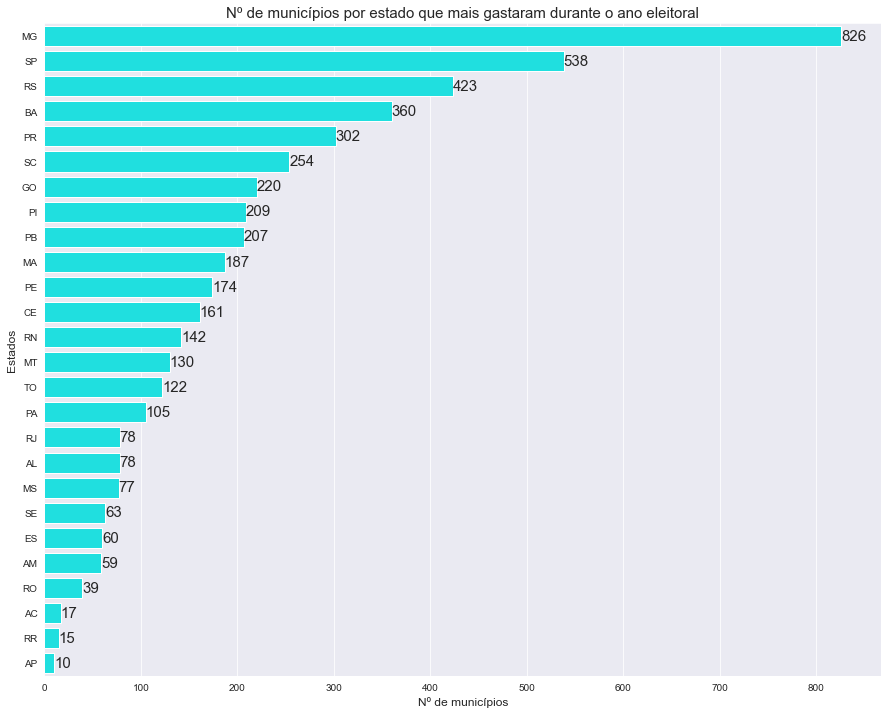

In [225]:
#plotando
plt.figure(figsize=(15, 12))
plot = sns.barplot(x=df_estados['nº_municípios_max_despesa_2020'],y = df_estados.index,data=df_max_ano,color = 'cyan')
plot.bar_label(plot.containers[0], size= 15)
plt.title("Nº de municípios por estado que mais gastaram durante o ano eleitoral",fontsize =15)
plt.xlabel('Nº de municípios', fontsize = 12)
plt.ylabel('Estados',fontsize=12)

Mas, quanto em média os municípios brasileiros gastam mais em ano eleitoral em comparação com o gasto total de um mandato? utilizando a coluna **soma_total**, que é a soma do gasto de 2017 à 2020, podemos achar a proporção do gasto para cada ano **media_anual**.

Text(0.5, 0, 'Ano')

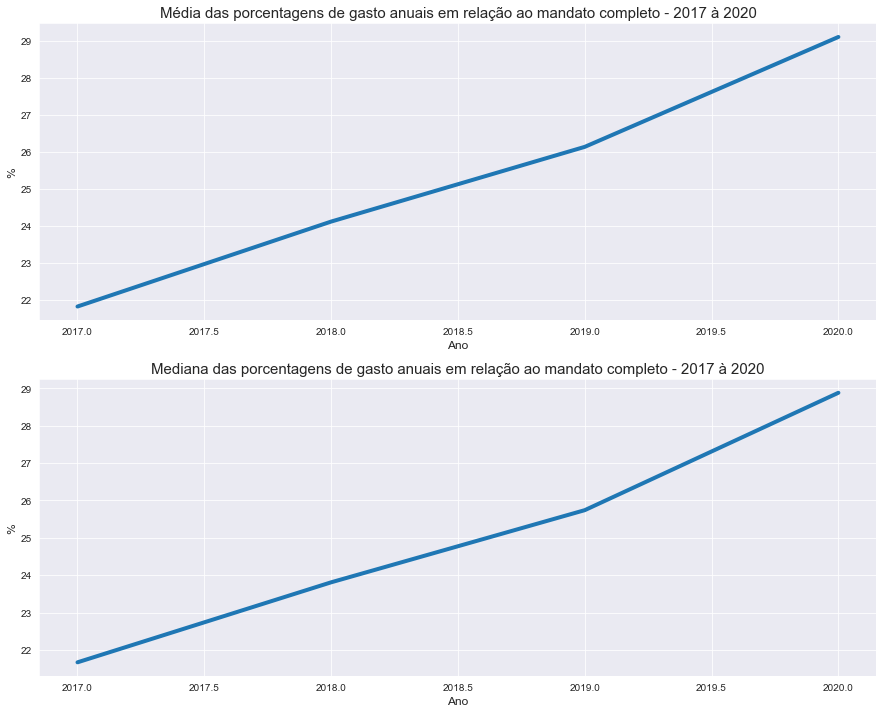

In [226]:
f, ax = plt.subplots(2,1, figsize=(15,12))

df_g1.groupby('ano')['media_anual'].mean().plot(linewidth = 4,ax = ax[0])
ax[0].set_title('Média das porcentagens de gasto anuais em relação ao mandato completo - 2017 à 2020',fontsize =15)
ax[0].set_ylabel('%', fontsize=12)
ax[0].set_xlabel('Ano',fontsize=12)


df_g1.groupby('ano')['media_anual'].median().plot(linewidth = 4,ax = ax[1])
ax[1].set_title('Mediana das porcentagens de gasto anuais em relação ao mandato completo - 2017 à 2020',fontsize =15)
ax[1].set_ylabel('%', fontsize=12)
ax[1].set_xlabel('Ano',fontsize=12)




In [227]:
ano_n = round(df_g1[df_g1.ano_eleitoral=='Não']['media_anual'].mean(),2)
ano_e = round(df_g1[df_g1.ano_eleitoral=='Sim']['media_anual'].mean(),2)
print(ano_e,ano_n)

29.11 24.03


Em geral, a média dos gastos anuais em comparação com o gasto total de um determinado mandato de prefeito em  um ano não eleitoral é de % 24,03, enquanto que em 2020 esse número aumentou para % 29,11.

Visto todas as informações acima, parece que o ano eleitoral é especialmente atrativo para o aumento do valor da conta Despesas Pagas para as prefeituras de todo o Brasil, com um aumento em média de 5% em relação ao gasto anual em um ano comum. 

Logo, podemos concluir com um certo grau de certeza que os buracos tapados nas ruas de sua cidade durante o ano eleitoral não são mero acaso - e que, inclusive, os buracos são tapados do Oiapoque ao Chuí. 

Portanto, da próxima vez que você ver um asfalto bonito, aproveite, pois são altas as chances de você ter que se preocupar com a suspensão de seu carro pelos próximos quatro anos.